In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import L_BFGS_B, SPSA
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import QuantumCircuit
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

seed = 69
mapper = JordanWignerMapper()
driver = PySCFDriver(
    atom=f"H 0 0 0; H 0 0 0.725",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

def create_ansatz(es_problem):
    return UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

def create_vqe_solver(estimator, ansatz):
    vqe_solver = VQE(estimator, ansatz, SPSA())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    return vqe_solver

class ThermalNoiseModel(NoiseModel):
    def __init__(self, t1s, t2s):
        super().__init__()
        self.t1s = t1s
        self.t2s = t2s
        # self.t1s = np.random.normal(100e3, 10e3, 4) # in us
        # self.t2s = np.random.normal(140e3, 10e3, 4)
        # self.t2s = np.array([min(self.t2s[j], 2 * self.t1s[j]) for j in range(4)])

        self.time_cx = 300
        self.time_reset = 1000
        self.time_measure = 1000

        self.add_errors()

    def add_errors(self):
        errors_cx = [[thermal_relaxation_error(t1a, t2a, self.time_cx).expand(thermal_relaxation_error(t1b, t2b, self.time_cx))
              for t1a, t2a in zip(self.t1s, self.t2s)] for t1b, t2b in zip(self.t1s, self.t2s)]
        errors_reset = [thermal_relaxation_error(t1, t2, self.time_reset) for t1, t2 in zip(self.t1s, self.t2s)]
        errors_measure = [thermal_relaxation_error(t1, t2, self.time_measure) for t1, t2 in zip(self.t1s, self.t2s)]

        for j in range(4):
            self.add_quantum_error(errors_reset[j], "reset", [j])
            self.add_quantum_error(errors_measure[j], "measure", [j])
            for k in range(4):
                self.add_quantum_error(errors_cx[j][k], "cx", [j, k])


class EnergyCalculator:
    def __init__(self, acc):
        t1s = np.random.normal(acc * 10e3, acc * 1e3, 4)
        t2s = np.random.normal(acc * 15e3, acc * 1e3, 4)
        t2s = np.array([min(t2s[j], 2 * t1s[j]) for j in range(4)])
        self.estimator = AerEstimator(
            backend_options={
                "method": "density_matrix",
                "coupling_map": [(0, 1), (1, 2), (2, 3), (3, 4)],
                "noise_model": ThermalNoiseModel(t1s, t2s),
            },
            run_options={"seed": seed, "shots": 1024},
            transpile_options={"seed_transpiler": seed},
        )
        self.calc = GroundStateEigensolver(mapper, create_vqe_solver(self.estimator, ansatz))
        self.vqe_energies = []

    def calculate(self):
        self.vqe_energies = []
        for distance in distances:
            driver = PySCFDriver(
                atom=f"H 0 0 0; H 0 0 {distance}",
                basis="sto3g",
                charge=0,
                spin=0,
                unit=DistanceUnit.ANGSTROM,
            )
            es_problem = driver.run()
            res = self.calc.solve(es_problem)
            self.vqe_energies.append(res.eigenvalues[0] + res._nuclear_repulsion_energy)

    def minimum(self):
        interpolated_function = interp1d(distances, self.vqe_energies, kind='cubic')
        result = minimize_scalar(interpolated_function, bounds=(distances.min(), distances.max()), method='bounded')
        return result.fun, result.x

es_problem = driver.run()
ansatz = create_ansatz(es_problem)
# distances = np.hstack((np.arange(0.2, 1.55, 0.05), np.arange(1.75, 4.25, 0.25)))
distances = np.arange(0.5, 1.55, 0.05)

accuracies = np.arange(1, 21, 2)

results = []
for accuracy in tqdm(accuracies, desc="Evaluating simulation"):
    calculator = EnergyCalculator(accuracy)
    calculator.calculate()
    results.append(calculator.minimum())

Evaluating simulation:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_86161/1495512876.py:124: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  calculator = EnergyCalculator(accuracy)
Evaluating simulation:  10%|█         | 1/10 [00:48<07:18, 48.70s/it]/tmp/ipykernel_86161/1495512876.py:124: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  calculator = EnergyCalculator(accuracy)
Evaluating simulation:  20%|██        | 2/10 [01:37<06:30, 48.86s/it]/tmp/ipykernel_86161/1495512876.py:124: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator fro

In [10]:
energies = []
for result in results:
    energies.append(result[0].item())

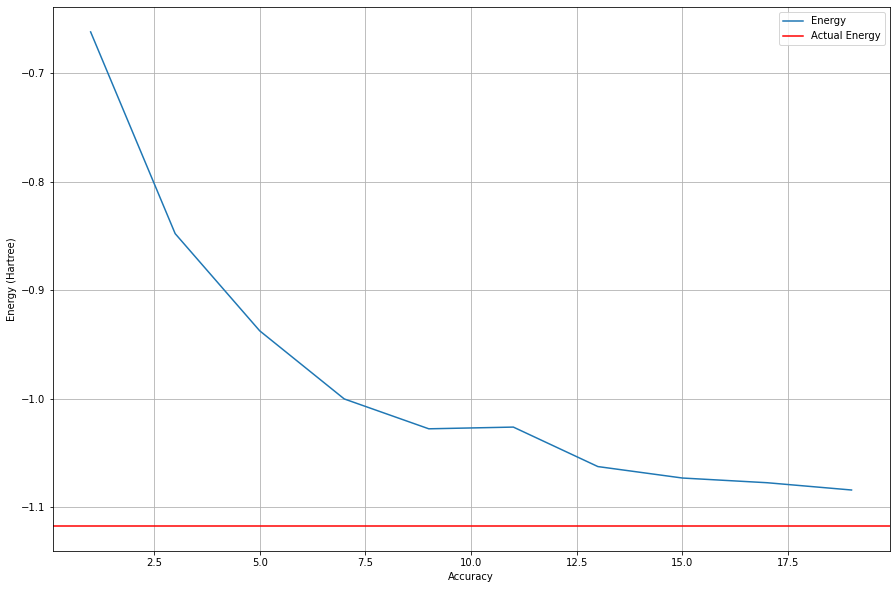

In [11]:
plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(accuracies, energies, label="Energy")
plt.axhline(y=-1.117506, color='r', label="Actual Energy")
plt.xlabel('Accuracy')
plt.ylabel('Energy (Hartree)')
plt.grid(True)
plt.legend()
plt.show()